## Multi-Stage Enhancement of Breast Ultrasound Images: A Comparative Study of Image Processing Techniques

### IMPORTS

In [253]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.restoration import denoise_tv_chambolle
from skimage.metrics import mean_squared_error, normalized_root_mse
from sklearn.metrics import f1_score
from skimage.feature import local_binary_pattern
from scipy.ndimage import gaussian_gradient_magnitude
from skimage.filters import gabor
from skimage import exposure
import pywt




### ORIGINAL IMAGE

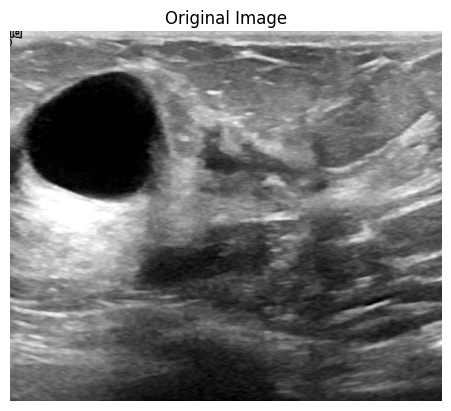

In [3]:

def read_and_display_image(image_path):
    image = cv2.imread(image_path, 0)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("Original Image")
    plt.show()

read_and_display_image('image2.png')


### STEP1: SPECKLE NOISE REDUCTION

#### Non Local Means Denoising

In [39]:

def nlm_denoising(image):
    """
    Parameters:
        h (float): Strength of filtering; higher values remove more noise but may also remove details.
        templateWindowSize (int): Size of the window around each pixel to compute similarity.
        searchWindowSize (int): Size of the search window for averaging pixels.
    """
    return cv2.fastNlMeansDenoising(image, h=12, templateWindowSize=7, searchWindowSize=21)

#### MEDIAN FILTERING

In [40]:
def median_filter(image, kernel_size=3):
    """
    Parameters:
    - kernel_size (int): Size of the filter window (odd integer).
    # Tried with various kernel sizes, but best result with 3
    """
    return cv2.medianBlur(image, kernel_size)

#### BILATERAL FILTERING

In [ ]:
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 7, 100, 100)   #tried with various kernel sizes but by far best result from kernel size 7

#### ANISOTROPIC DIFFUSION

In [41]:
def anisotropic_diffusion(image, num_iter=15, kappa=40, gamma=0.15):
    """
    Parameters:
    - num_iter (int): Number of iterations (higher values result in more smoothing).
    - kappa (float): Controls sensitivity to edges.
    - gamma (float): Step size for smoothing (higher values lead to more diffusion).
    """
    img = image.astype('float32')
    for i in range(num_iter):
        nablaN = np.roll(img, 1, axis=0) - img
        nablaS = np.roll(img, -1, axis=0) - img
        nablaE = np.roll(img, 1, axis=1) - img
        nablaW = np.roll(img, -1, axis=1) - img
        
        cN = np.exp(-(nablaN / kappa) ** 2)
        cS = np.exp(-(nablaS / kappa) ** 2)
        cE = np.exp(-(nablaE / kappa) ** 2)
        cW = np.exp(-(nablaW / kappa) ** 2)
        
        img += gamma * (cN * nablaN + cS * nablaS + cE * nablaE + cW * nablaW)
    return img.astype('uint8')


#### WAVELET THRESHOLDING

In [44]:
def wavelet_thresholding(image):
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs = list(coeffs)
    coeffs[1:] = [(pywt.threshold(cH, threshold, mode='soft'), 
                   pywt.threshold(cV, threshold, mode='soft'),
                   pywt.threshold(cD, threshold, mode='soft')) for cH, cV, cD in coeffs[1:]]
    return pywt.waverec2(coeffs, 'haar')


#### PSNR AND SSIM EVALUATOR

In [43]:
def evaluate_metrics(original, processed):
    psnr = peak_signal_noise_ratio(original, processed, data_range=original.max() - original.min())
    ssim = structural_similarity(original, processed, data_range=original.max() - original.min())   #ranges from -1 to 1
    return psnr, ssim


#### DISPLAY IMAGES AND RETURN BEST IMAGE

In [46]:
def display_and_evaluate(image):
    methods = {
        'NLM Denoising': nlm_denoising(image),
        'Median Filtering': median_filter(image),
        'Anisotropic Diffusion': anisotropic_diffusion(image),
        'Wavelet Thresholding': wavelet_thresholding(image),
        'Bilateral Filtering': bilateral_filter(image)
    }

    original = image
    best_method = None
    best_psnr = -1
    best_ssim = -1
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        processed_image = cv2.resize(processed_image, (original.shape[1], original.shape[0]))
        psnr, ssim = evaluate_metrics(original, processed_image)
        plt.subplot(2, 3, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nPSNR: {psnr:.2f}, SSIM: {ssim:.3f}")
        plt.axis('off')

        if psnr > best_psnr and ssim > best_ssim:
            best_psnr = psnr
            best_ssim = ssim
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with PSNR: {best_psnr:.2f} and SSIM: {best_ssim:.3f}")
    return best_image


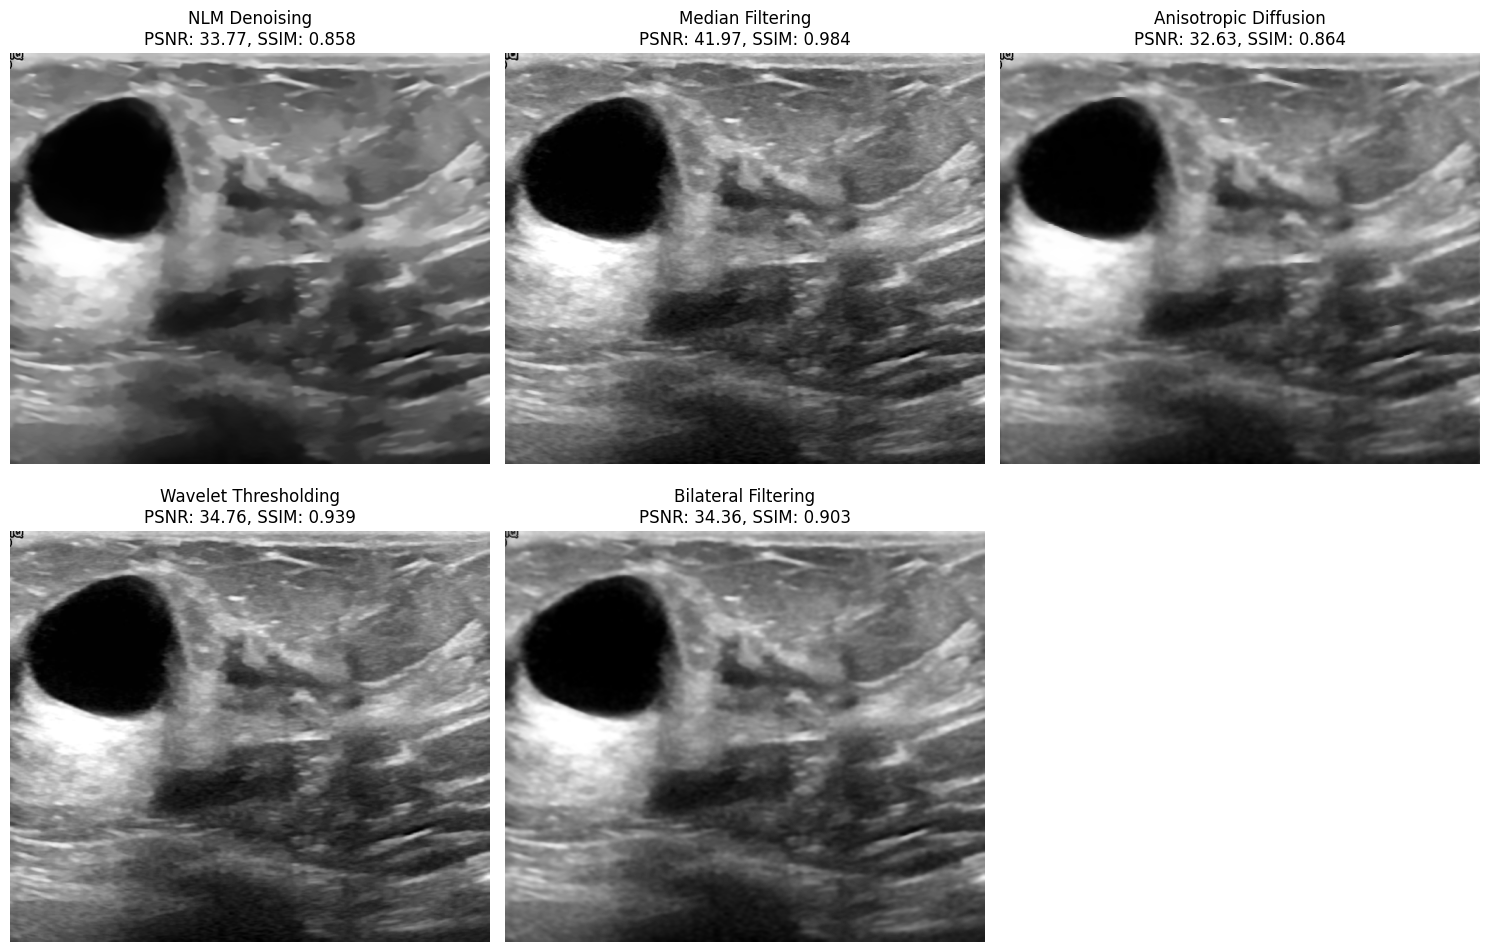

Best Method: Median Filtering with PSNR: 41.97 and SSIM: 0.984


In [313]:
original_image = cv2.imread('image2.png',0)
best_image = display_and_evaluate(original_image)

#### BEST IMAGE TO BE TAKEN FOR NEXT STEP

In [48]:
med_filt_image = best_image

### STEP2: CONTRAST ENHANCEMENT

#### CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [ ]:
def apply_clahe(image):
    """
    Parameters:
    - clipLimit (float): Limits contrast amplification to prevent over-enhancement in homogeneous areas.
    - tileGridSize (tuple): The image is divided into small tiles of size 8x8 or 4x4, and contrast enhancement is applied individually to each tile.
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))  # Tried grid size with (8, 8) but (4, 4) is the best one
    return clahe.apply(image)


#### Histogram Equalization


In [50]:
def histogram_equalization(image):
    return cv2.equalizeHist(image)

#### Gamma Correction


In [51]:
def gamma_correction(image, gamma=1.2):
    """
    Parameters:
    - gamma (float): Controls brightness enhancement, with values greater than 1 brightening the image.
    """
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)


#### Brightness and Contrast Adjustment

In [66]:
def adjust_brightness_contrast(image, alpha=1.1, beta=15):
    """
    Parameters:
    - alpha (float): Scaling factor for contrast; values greater than 1 increase contrast.
    - beta (int): Shift factor for brightness; values greater than 0 increase brightness.
    """
    # alpha > 1 to increase contrast, beta > 0 to increase brightness
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)


#### Contrast Improvement Index (CII) Evaluation

In [75]:
def contrast_improvement_index(original, enhanced):
    #This metric evaluates how well contrast is enhanced by comparing the standard deviation to the mean in the original and processed images. 
    mean_orig = np.mean(original)
    mean_enh = np.mean(enhanced)
    std_orig = np.std(original)
    std_enh = np.std(enhanced)
    return (std_enh / mean_enh) / (std_orig / mean_orig)


#### DISPLAY IMAGE AND RETURN THE BEST ONE

In [54]:
def display_and_evaluate_contrast(image):
    methods = {
        'CLAHE': apply_clahe(image),
        'Histogram Equalization': histogram_equalization(image),
        'Gamma Correction': gamma_correction(image),
        'Brightness/Contrast Adjustment': adjust_brightness_contrast(image)
    }

    original = image
    best_method = None
    best_cii = -1
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        cii = contrast_improvement_index(original, processed_image)
        plt.subplot(2, 3, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nCII: {cii:.3f}")
        plt.axis('off')
        
        if cii > best_cii:
            best_cii = cii
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with CII: {best_cii:.3f}")
    return best_image


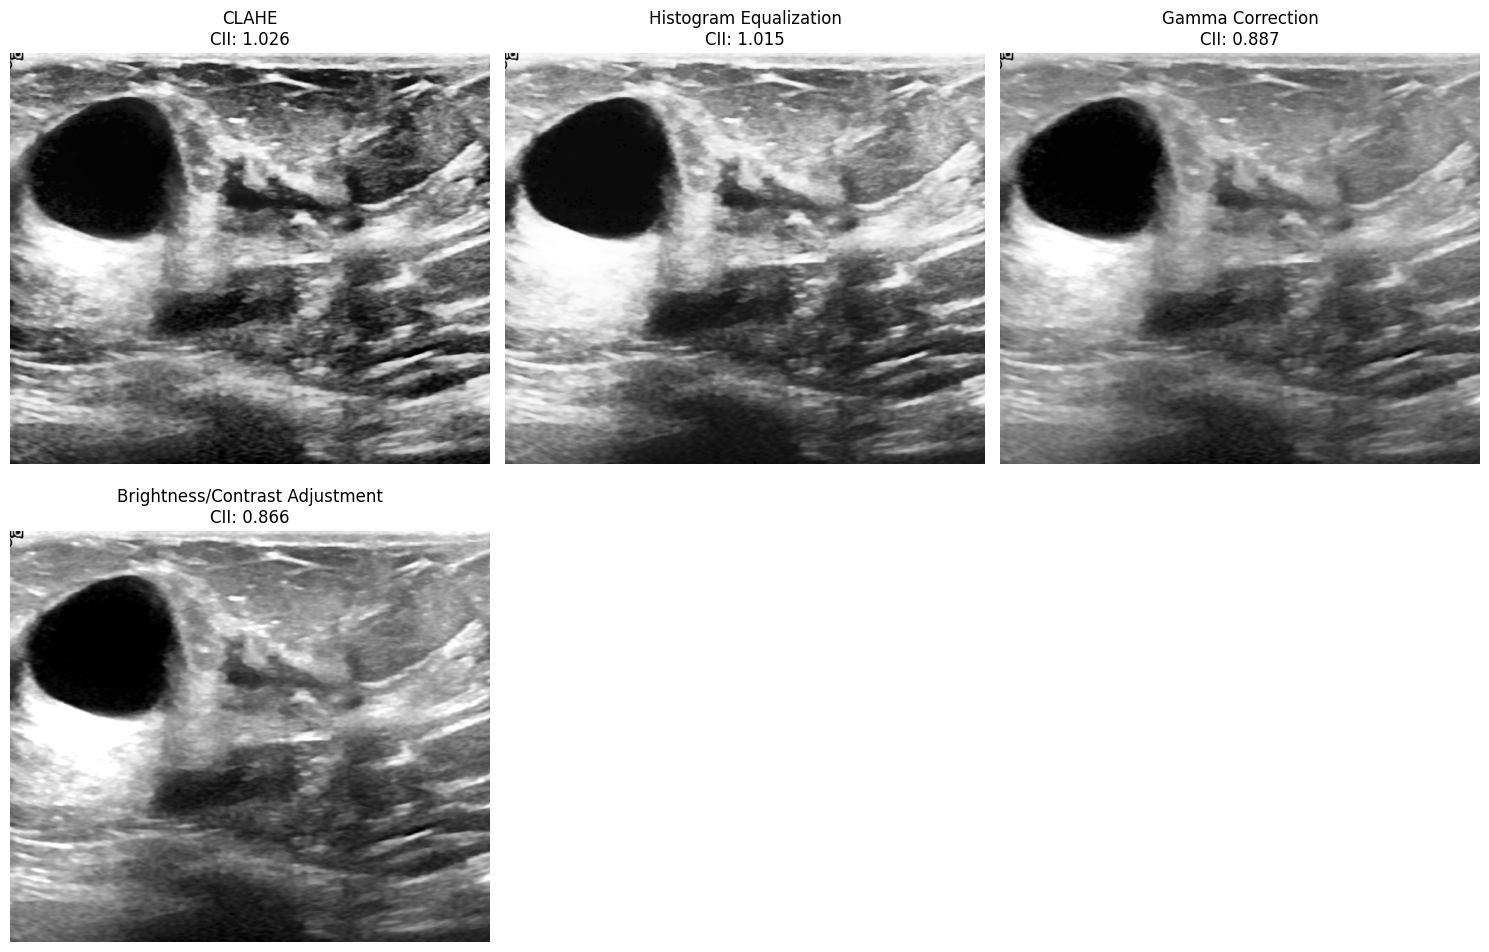

Best Method: CLAHE with CII: 1.026


In [67]:
best_image = display_and_evaluate_contrast(med_filt_image)

In [57]:
clahe_img = best_image

### STEP3: ARTIFACT SUPRESSION

#### WAVELET ARTIFACT REDUCTION

In [69]:
def wavelet_artifact_reduction(image):
    """
    Parameters:
    - Uses 'haar' wavelet and applies thresholding to reduce artifacts.
    """
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs[1:] = [(pywt.threshold(cH, threshold, mode='soft'), 
                   pywt.threshold(cV, threshold, mode='soft'),
                   pywt.threshold(cD, threshold, mode='soft')) for cH, cV, cD in coeffs[1:]]
    return pywt.waverec2(coeffs, 'haar')


#### NLM ARTIFACT SUPRESSION

In [71]:
def nlm_artifact_suppression(image):
    """
    Parameters:
    - h (int): Filter strength; higher values result in more noise removal but may also remove details.
    - templateWindowSize (int): Size of the window around each pixel to compute similarity.
    - searchWindowSize (int): Size of the search window for averaging pixels.
    """
    return cv2.fastNlMeansDenoising(image, h=12, templateWindowSize=7, searchWindowSize=21)


#### TOTAL VARIATION MINIMIZATION

In [93]:
def total_variation_minimization(image):
    """
    Parameters:
    - weight (float): Controls the amount of smoothing; higher values result in more smoothing.
    """
    return denoise_tv_chambolle(image, weight=0.1)


#### KALMAN FILTERING

In [85]:
def kalman_filter(image):
    """
    Parameters:
    - measurementMatrix: Matrix that maps the true state space into the measurement space.
    - transitionMatrix: Defines the relation between the previous and current state.
    - processNoiseCov: Covariance of the process noise; a small value improves tracking but may limit adaptability.
    - measurementNoiseCov: Covariance of the measurement noise; controls the noise level in the measurements.
    - statePost: Initial state estimate, set to a random value in this function.
    """
    kalman = cv2.KalmanFilter(4, 2)
    kalman.measurementMatrix = np.eye(2, 4, dtype=np.float32)
    kalman.transitionMatrix = np.eye(4, dtype=np.float32)
    kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 1e-5
    kalman.measurementNoiseCov = np.eye(2, dtype=np.float32) * 1e-1
    kalman.statePost = np.random.randn(4).astype(np.float32)
    
    smoothed_image = np.copy(image)
    for i in range(1, image.shape[1]):
        measurement = np.array([[image[0, i]], [image[1, i]]], dtype=np.float32)
        kalman.correct(measurement)
        predicted = kalman.predict()
        smoothed_image[0, i] = predicted[0, 0]
        smoothed_image[1, i] = predicted[1, 0]
        
    return smoothed_image


#### ADAPTIVE MEDIAN FILTERING

In [89]:
def adaptive_median_filtering(image, kernel_size=7):
    return cv2.medianBlur(image, kernel_size)


#### Artifact Reduction Ratio (ARR) Evaluation


In [76]:
def artifact_reduction_ratio(original, enhanced):
    # ARR compares noise or artifact reduction between the original and enhanced image
    original_artifacts = np.std(original)
    enhanced_artifacts = np.std(enhanced)
    return (original_artifacts - enhanced_artifacts) / original_artifacts


#### DISPLAY AND RETURN BEST IMAGE

In [77]:
def display_and_evaluate_artifact(image):
    methods = {
        'Wavelet Artifact Reduction': wavelet_artifact_reduction(image),
        'Non-Local Means Artifact Suppression': nlm_artifact_suppression(image),
        'Total Variation Minimization': total_variation_minimization(image),
        'Kalman Filtering': kalman_filter(image),
        'Adaptive Median Filtering': adaptive_median_filtering(image)
    }

    original = image
    best_method = None
    best_arr = -1
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        arr = artifact_reduction_ratio(original, processed_image)
        plt.subplot(2, 3, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nARR: {arr:.3f}")
        plt.axis('off')

        # Select the best based on Artifact Reduction Ratio (ARR)
        if arr > best_arr:
            best_arr = arr
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with ARR: {best_arr:.3f}")
    return best_image


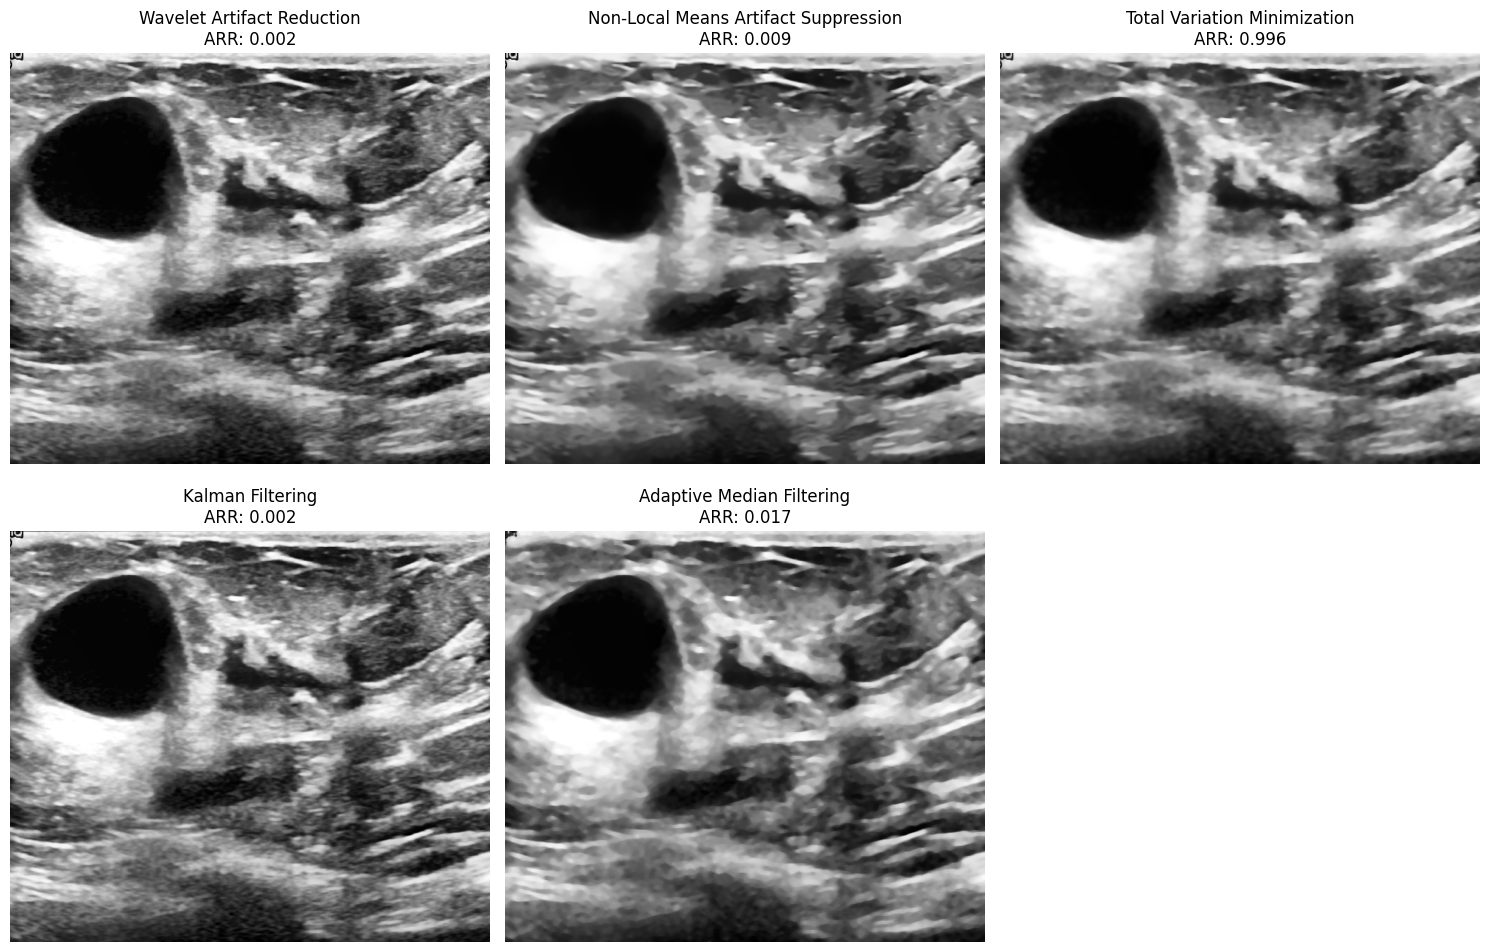

Best Method: Total Variation Minimization with ARR: 0.996


In [94]:
best_image = display_and_evaluate_artifact(clahe_img)

In [95]:
tvmin_img = best_image

### STEP4: IMAGE BRIGHTNESS NORMALIZATION

#### CLAHE

In [171]:
def adaptive_histogram_equalization(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    return clahe.apply(image)


#### Brightness Adjustment with Gamma Correction


In [116]:
def gamma_correction(image, gamma=1.1):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)



#### CONTRAST STRETCHING

In [99]:
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)


#### Mean Squared Error (MSE) Evaluation


In [101]:
def mean_squared_error_metric(original, enhanced):
    # Measures the average squared difference between original and enhanced images.
    return mean_squared_error(original, enhanced)


#### Normalized Root Mean Square Error (NRMSE) Evaluation


In [102]:
def normalized_rmse_metric(original, enhanced):
    return normalized_root_mse(original, enhanced)


#### DISPLAY AND RETURN BEST IMAGE

In [120]:
def display_and_evaluate_brightness_contrast(image):
    methods = {
        'Adaptive Histogram Equalization': adaptive_histogram_equalization(image),
        'Gamma Correction': gamma_correction(image),
        'Contrast Stretching': contrast_stretching(image)
    }

    original = image
    best_method = None
    best_score = float('inf')
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        mse = mean_squared_error_metric(original, processed_image)
        nrmse = normalized_rmse_metric(original, processed_image)
        plt.subplot(2, 3, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nMSE: {mse:.3f}, NRMSE: {nrmse:.3f}")
        plt.axis('off')

        # Select the best based on MSE or NRMSE (lower is better)
        if nrmse < best_score:
            best_score = nrmse
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with NRMSE: {best_score:.3f}")
    return best_image

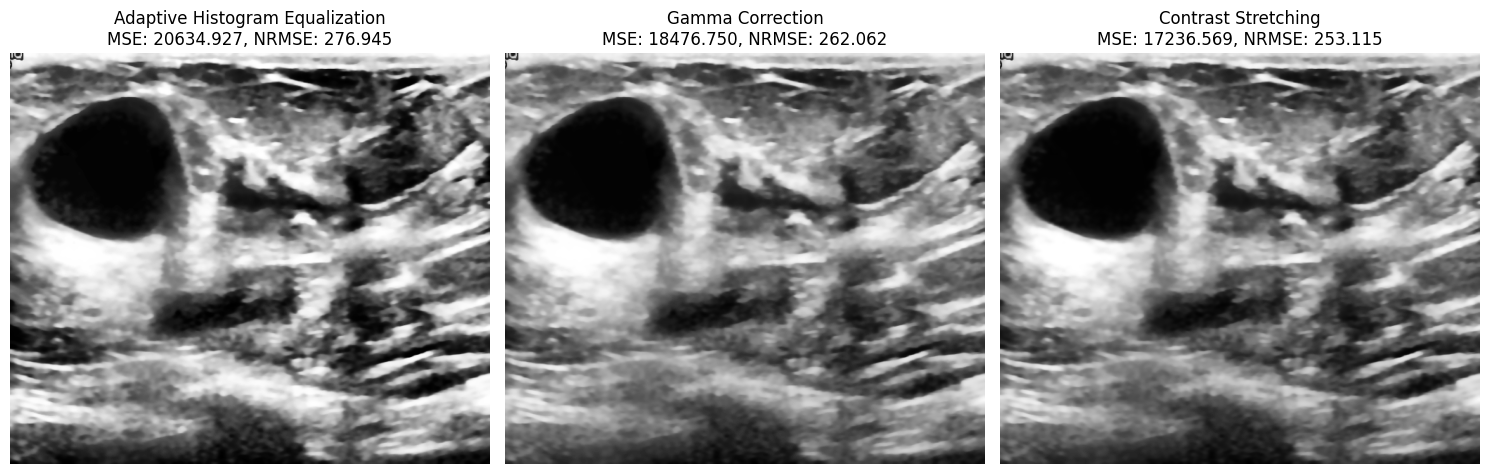

Best Method: Contrast Stretching with NRMSE: 253.115


In [172]:
best_image = display_and_evaluate_brightness_contrast(tvmin_img)

In [122]:
cntstr_img = best_image

### STEP5: EDGE ENHANCEMENT

#### UNSHARP MASKING

In [182]:
def unsharp_masking(image):
    """
    Parameters:
    - GaussianBlur (9, 9): Defines the blur kernel size for smoothing.
    """
    gaussian_blurred = cv2.GaussianBlur(image, (9, 9), 10.0)              # best kernel size is (9,9)
    return cv2.addWeighted(image, 1.5, gaussian_blurred, -0.5, 0)


#### LAPLACIAN OF GAUSSIAN(LoG)

In [176]:
def laplacian_of_gaussian_enhancement(image):
    """
    Applies the Laplacian of Gaussian (LoG) for edge detection and enhances the image
    by overlaying the detected edges onto the original image.
    Parameters:
    - GaussianBlur: Smoothing kernel size before applying the Laplacian operator.    ()
    """
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    
    blurred_image = cv2.GaussianBlur(image, (9,9), 0)      # tried with various kernel sizes (9,9) is the best
    
    edges = cv2.Laplacian(blurred_image, cv2.CV_64F)
    
    edges = cv2.convertScaleAbs(edges)
    
    if len(image.shape) == 3:
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    else:
        edges_colored = edges

    edges_colored = edges_colored.astype(np.uint8)
    
    enhanced_image = cv2.addWeighted(image, 0.8, edges_colored, 0.2, 0)
    
    return enhanced_image


#### Canny Edge Detection


In [165]:
def canny_edge_enhancement(image):
    """
    Parameters:
    - Thresholds: control edge detection sensitivity.
    """
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    
    edges = cv2.Canny(image, 240, 250)
    
    if len(image.shape) == 3:
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    else:
        edges_colored = edges
 
    enhanced_image = cv2.addWeighted(image, 0.8, edges_colored, 0.2, 0)
    
    return enhanced_image


#### Sobel Filter


In [162]:
def sobel_edge_enhancement(image):
    """
    Applies the Sobel filter for edge detection and enhances the image
    by overlaying the detected edges onto the original image.
    Parameters:
    - ksize=5: Kernel size for Sobel operator.
    """
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    

    edges = cv2.magnitude(sobelx, sobely)
    

    edges = cv2.convertScaleAbs(edges)
    

    if len(image.shape) == 3:
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    else:
        edges_colored = edges
    
    enhanced_image = cv2.addWeighted(image, 0.8, edges_colored, 0.2, 0)
    
    return enhanced_image



####  Edge Detection Accuracy/F1 Score Evaluation


In [181]:
def edge_detection_accuracy(original, enhanced):
    # Compares the edges found in the processed image to those in the original image using the F1 score.
    if original.dtype != np.uint8:
        original = cv2.convertScaleAbs(original)
    if enhanced.dtype != np.uint8:
        enhanced = cv2.convertScaleAbs(enhanced)
    original_edges = cv2.Canny(original, 100, 200)
    enhanced_edges = cv2.Canny(enhanced, 100, 200)
    
    original_edges_flat = original_edges.flatten() > 0
    enhanced_edges_flat = enhanced_edges.flatten() > 0
    
    return f1_score(original_edges_flat, enhanced_edges_flat)


#### DISPLAY AND RETURN BEST IMAGE

In [163]:
def display_and_evaluate_edges(image):
    methods = {
        'Unsharp Masking': unsharp_masking(image),
        'Laplacian of Gaussian (LoG)': laplacian_of_gaussian_enhancement(image),
        'Canny Edge Detection': canny_edge_enhancement(image),
        'Sobel Filter': sobel_edge_enhancement(image)
    }

    original = image
    best_method = None
    best_f1_score = -1
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        f1 = edge_detection_accuracy(original, processed_image)
        plt.subplot(2, 3, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nF1 Score: {f1:.3f}")
        plt.axis('off')

        # Select the best based on F1 Score
        if f1 > best_f1_score:
            best_f1_score = f1
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with F1 Score: {best_f1_score:.3f}")
    return best_image

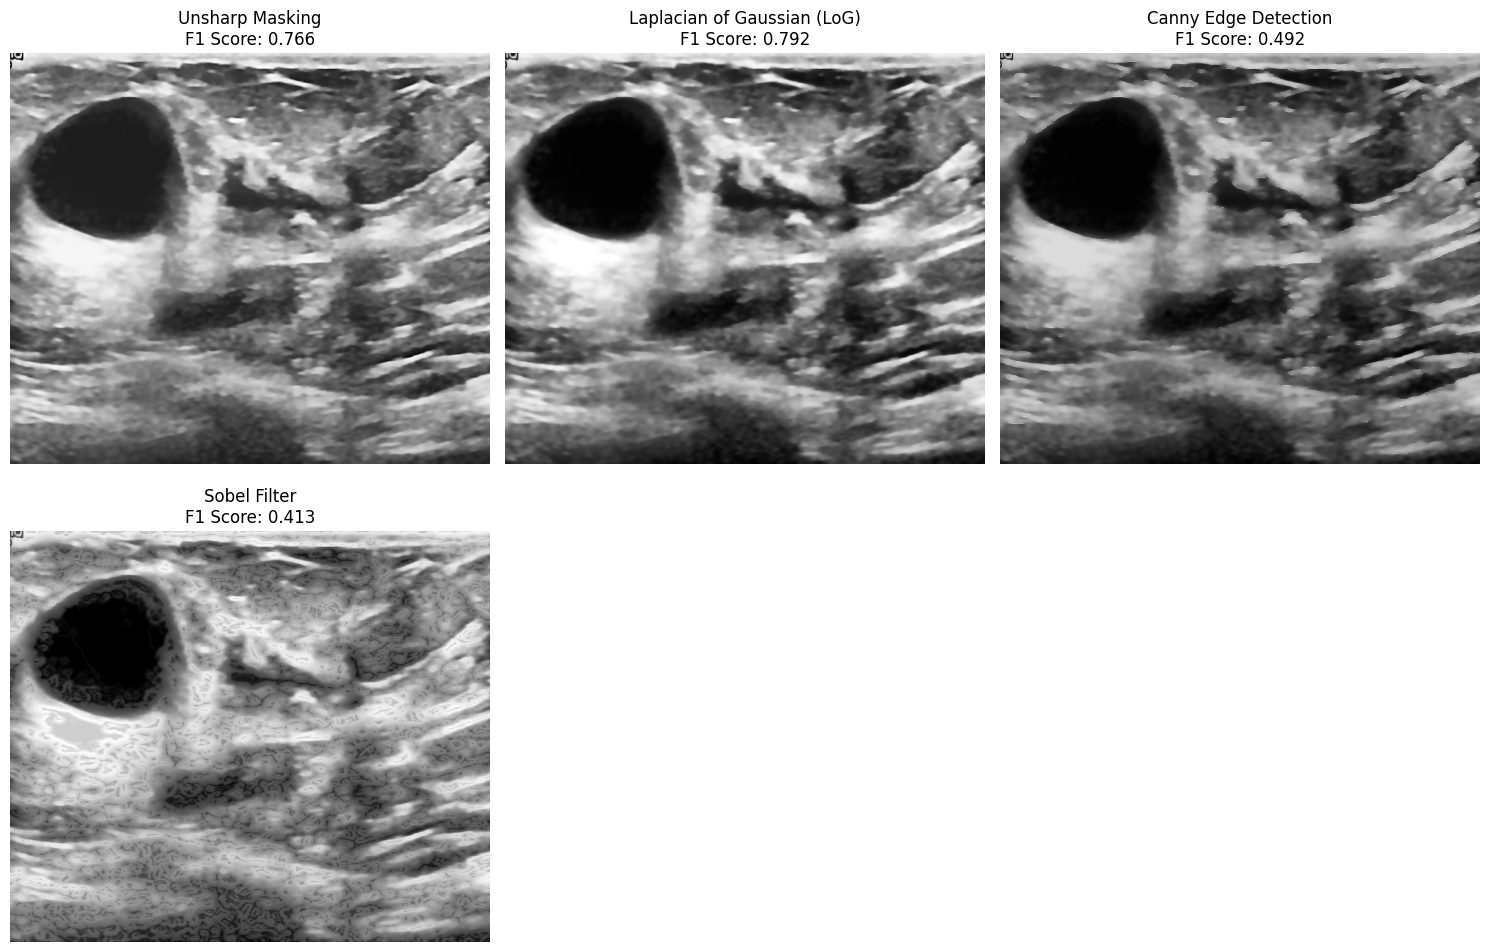

Best Method: Laplacian of Gaussian (LoG) with F1 Score: 0.792


In [177]:
best_image = display_and_evaluate_edges(cntstr_img)

In [178]:
log_img = best_image

### STEP6: SHADOW SUPRESSION

#### Illumination Compensation 

In [183]:
def illumination_compensation(image):
    # normalizes image illumination
    return exposure.equalize_adapthist(image / 255.0) * 255


#### Retinex Algorithm


In [213]:
def retinex_algorithm_enhancement(image):
    """
    Parameters:
    - GaussianBlur (21, 21): Kernel size for smoothing.
    """
    image_float = np.float64(image) + 1.0  # Adding 1 to avoid log(0)
    
    log_image = np.log(image_float)
    log_gaussian = np.log(cv2.GaussianBlur(image_float, (11, 11), 30))
    
    retinex_result = log_image - log_gaussian
    retinex_normalized = cv2.normalize(retinex_result, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    
    enhanced_image = cv2.addWeighted(image, 0.8, retinex_normalized, 0.2, 0)
    
    return enhanced_image


#### Morphological Shadow Removal 

In [216]:
def shadow_removal_morphological(image):
    """
    Parameters:
    - Morphological kernel (5, 5): Size of the structuring element for closing.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


#### Gradient Domain Manipulation 

In [202]:
def gradient_domain_edge_enhancement(image):
    """
    Parameters:
    - Sobel (ksize=3): Gradient filter kernel size for edge detection.
    """
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    

    grad_magnitude = cv2.magnitude(grad_x, grad_y)
    
    grad_magnitude = cv2.convertScaleAbs(cv2.normalize(grad_magnitude, None, 0, 255, cv2.NORM_MINMAX))
    
   
    if len(image.shape) == 3:
        grad_magnitude_colored = cv2.cvtColor(grad_magnitude, cv2.COLOR_GRAY2BGR)
    else:
        grad_magnitude_colored = grad_magnitude
    

    enhanced_image = cv2.addWeighted(image, 0.8, grad_magnitude_colored, 0.2, 0)
    
    return enhanced_image


#### Shadow Suppression Ratio (SSR) Evaluation


In [211]:
def shadow_suppression_ratio(original, enhanced):
    # Measures the reduction in shadow or illumination variance between the original and enhanced images
    original_std = np.std(original)
    enhanced_std = np.std(enhanced)
    return (original_std - enhanced_std) / original_std


#### DISPLAY AND RETURN BEST IMAGE

In [207]:
def display_and_evaluate_shadow_suppression(image):
    methods = {
        'Illumination Compensation': illumination_compensation(image),
        'Retinex Algorithm': retinex_algorithm_enhancement(image),
        'Morphological Shadow Removal': shadow_removal_morphological(image),
        'Gradient Domain Manipulation': gradient_domain_edge_enhancement(image)
    }

    original = image
    best_method = None
    best_ssr = -1
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        # Calculate the Shadow Suppression Ratio (SSR)
        ssr = shadow_suppression_ratio(original, processed_image)
        
        # Plot the processed image
        plt.subplot(2, 3, i + 1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nSSR: {ssr:.3f}")
        plt.axis('off')

        # Select the best method based on SSR
        if ssr > best_ssr:
            best_ssr = ssr
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with SSR: {best_ssr:.3f}")
    return best_image

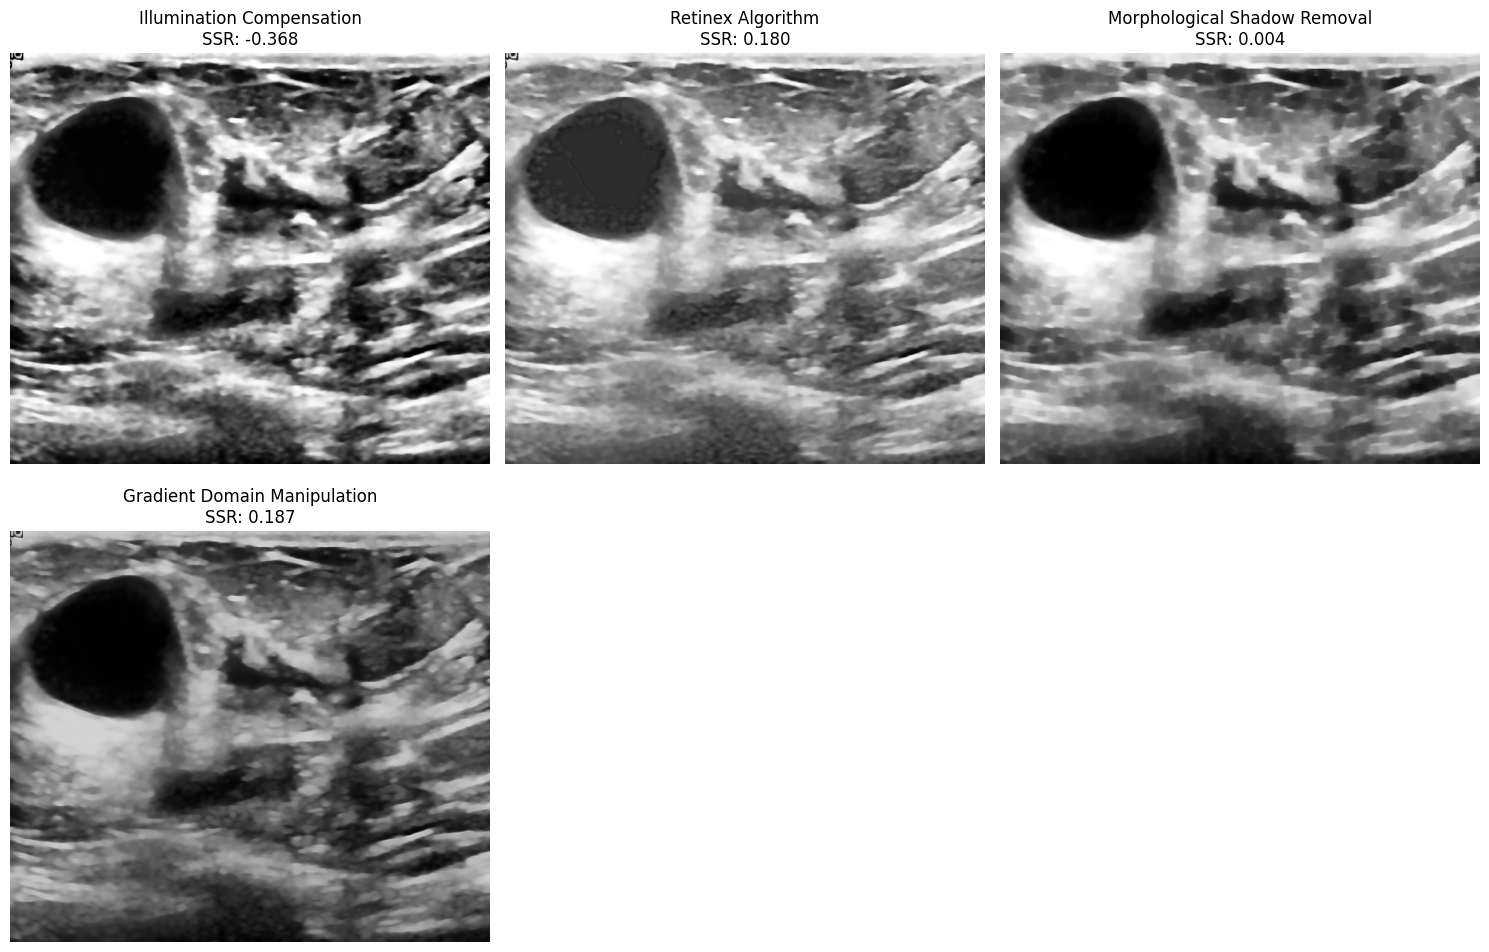

Best Method: Gradient Domain Manipulation with SSR: 0.187


In [217]:
best_image = display_and_evaluate_shadow_suppression(log_img)

In [215]:
gdman_img = best_image

### STEP7: DEPTH ATTENUATION COMPENSATION

#### Depth-Dependent Gain Control


In [248]:
def depth_dependent_gain_control(image, gain_factor=0.0004):
    """
    Parameters:
    - gain_factor (float): Controls how much brightness increases with depth; higher values increase brightness more with depth .
    """
    rows, cols = image.shape
    output = np.zeros_like(image)
    for i in range(rows):
        gain = 1 + gain_factor * i
        output[i, :] = np.clip(image[i, :] * gain, 0, 255)
    return output.astype(np.uint8)


#### Exponential Compensation

In [ ]:
def exponential_compensation(image, gamma=0.9):
    """
    Parameters:
    - gamma (float): Controls the degree of exponential compensation; lower values increase brightness more intensely.
    """
    exp_image = np.array(255 * (image / 255) ** gamma, dtype='uint8')
    return exp_image


#### Adaptive Gain Control 

In [233]:
def adaptive_gain_control(image):
    rows, cols = image.shape
    gain_map = np.linspace(1, 2, rows).reshape(-1, 1)
    output = np.clip(image * gain_map, 0, 255)
    return output.astype(np.uint8)


#### Image Inpainting Techniques

In [232]:
def inpainting_techniques(image):
    """
    Parameters:
    - Threshold mask: Identifies bright regions (pixel values above 220) for inpainting.
    """
    mask = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY)[1]
    return cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)


#### Uniformity Index (UI) Evaluation


In [226]:
def uniformity_index(image):
    # Measures the uniformity of brightness across the image by comparing the mean and standard deviation of pixel intensities.
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    return mean_intensity / std_intensity


#### DISPLAY AND RETURN BEST IMAGE

In [235]:
def display_and_evaluate_depth_compensation(image):
    methods = {
        'Depth-Dependent Gain Control': depth_dependent_gain_control(image),
        'Exponential Compensation': exponential_compensation(image),
        'Adaptive Gain Control': adaptive_gain_control(image),
        'Inpainting Techniques': inpainting_techniques(image)
    }

    original = image
    best_method = None
    best_ui = -1
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        ui = uniformity_index(processed_image)
        plt.subplot(2, 3, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nUI: {ui:.3f}")
        plt.axis('off')

        # Select the best based on Uniformity Index (UI)
        if ui > best_ui:
            best_ui = ui
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with UI: {best_ui:.3f}")
    return best_image


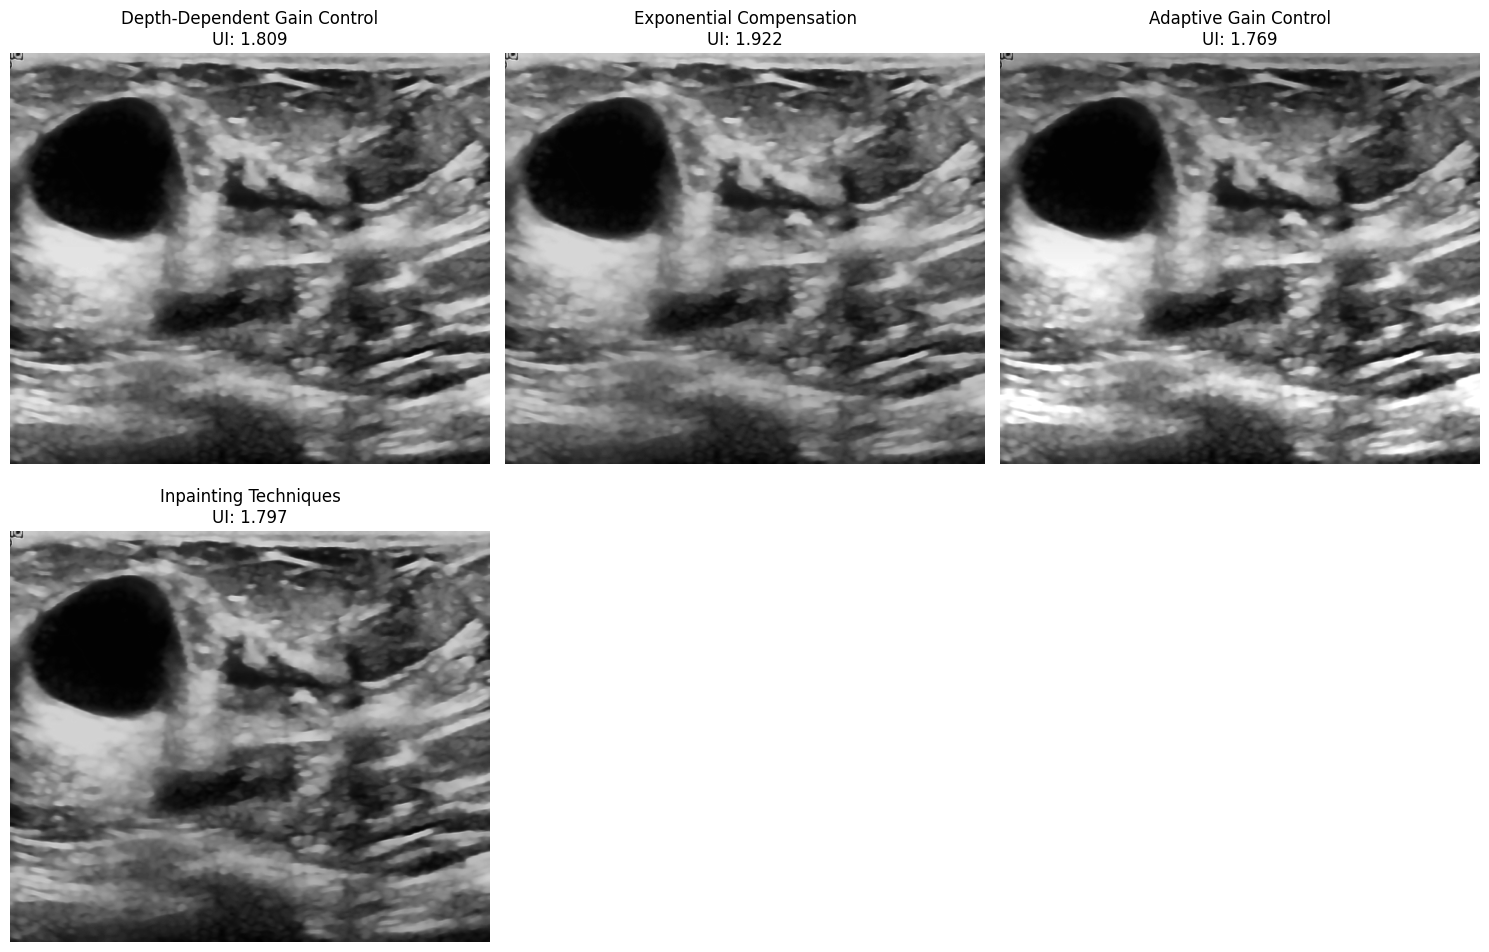

Best Method: Exponential Compensation with UI: 1.922


In [251]:
best_image = display_and_evaluate_depth_compensation(gdman_img)

In [252]:
expcomp_img = best_image

### STEP8: TEXTURE ENHANCEMENT

#### GABOR FILTERING

In [285]:
def gabor_texture_enhancement(image, frequency=0.95):
    """
    Enhances texture by applying a Gabor filter and blending with the original image.
    Parameters:
    - frequency (float): Controls the frequency of the Gabor filter, affecting texture detail.
    """
    filtered_real, _ = gabor(image, frequency=frequency)
   
    filtered_real_abs = np.abs(filtered_real)
    filtered_normalized = cv2.normalize(filtered_real_abs, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    
    enhanced_image = cv2.addWeighted(image, 0.8, filtered_normalized, 0.2, 0)
    
    return enhanced_image


#### Local Binary Patterns (LBP) 

In [294]:
def lbp_texture_enhancement(image, radius=1, n_points=8):
    """
    Enhances texture by applying Local Binary Patterns (LBP) and blending with the original image.
    Parameters:
    - radius: Distance from the center pixel.
    - n_points: Number of neighboring points to consider.
    """

    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    
    lbp_normalized = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)

    enhanced_image = cv2.addWeighted(image, 0.8, lbp_normalized, 0.2, 0)
    
    return enhanced_image


#### Fractal Dimension Analysis

In [306]:
def fractal_dimension(image):
    # Convert the image to binary
    binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)[1]
    binary_image = binary_image // 255  # Convert to 0 and 1

    def box_count(image, box_size):
        rows, cols = image.shape
        count = 0
        for i in range(0, rows, box_size):
            for j in range(0, cols, box_size):
                if np.any(image[i:i+box_size, j:j+box_size]):
                    count += 1
        return count

    box_sizes = np.array([2, 4, 8, 16, 32])
    counts = [box_count(binary_image, size) for size in box_sizes]

    coeffs = np.polyfit(np.log(box_sizes), np.log(counts), 1)
    print(coeffs[0])
    return -coeffs[0]


#### Gradient Magnitude Maps 

In [303]:
def gradient_magnitude_enhancement(image, sigma=0.2):
    """
    Enhances edges and texture by applying a gradient magnitude map and blending it with the original image.
    Parameters:
    - sigma (float): Controls the smoothness of the gradient calculation.
    """
    gradient_magnitude = gaussian_gradient_magnitude(image, sigma=sigma)
    
    gradient_normalized = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)

    enhanced_image = cv2.addWeighted(image, 0.8, gradient_normalized, 0.2, 0)
    
    return enhanced_image


#### Texture Contrast Ratio (TCR) Evaluation

In [258]:
def texture_contrast_ratio(original, enhanced):
    # Compares the contrast (standard deviation) between the original and enhanced images.
    original_contrast = np.std(original)
    enhanced_contrast = np.std(enhanced)
    return enhanced_contrast / original_contrast


In [297]:
def display_and_evaluate_texture_enhancement(image):
    methods = {
        'Gabor Filtering': gabor_texture_enhancement(image),
        'Local Binary Patterns (LBP)': lbp_texture_enhancement(image),
        'Fractal Dimension Analysis': fractal_dimension(image),
        'Gradient Magnitude Maps': gradient_magnitude_enhancement(image)
    }

    original = image
    best_method = None
    best_tcr = -1
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        # Skip fractal dimension analysis as it is not an image
        if method_name == 'Fractal Dimension Analysis':
            continue
        
        tcr = texture_contrast_ratio(original, processed_image)
        plt.subplot(2, 3, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nTCR: {tcr:.3f}")
        plt.axis('off')

        # Select the best based on Texture Contrast Ratio (TCR)
        if tcr > best_tcr:
            best_tcr = tcr
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with TCR: {best_tcr:.3f}")
    return best_image


-1.6027598932688476


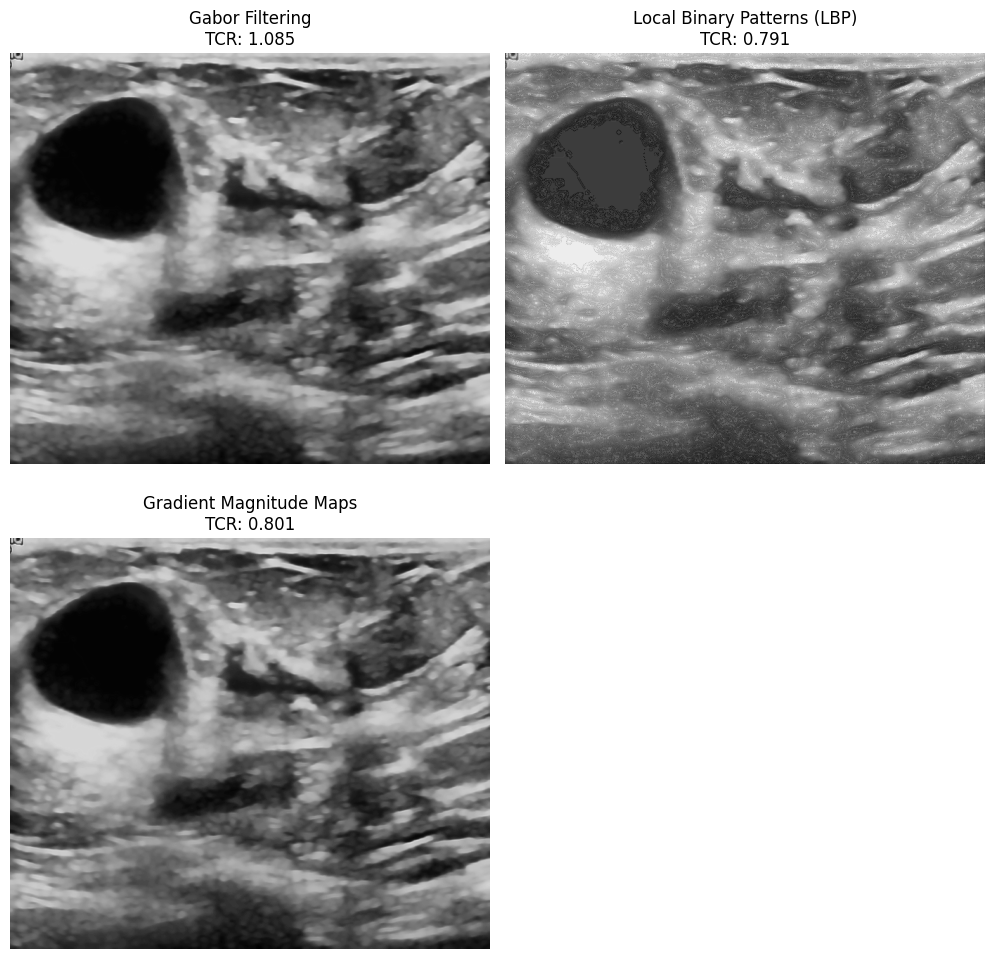

Best Method: Gabor Filtering with TCR: 1.085


In [307]:
best_image = display_and_evaluate_texture_enhancement(expcomp_img)

In [305]:
gbrfltr_img = best_image

### STEP9: NORMALIZATION FOR CONSISTENCY

#### Z SCORE NORMALIZATION

In [308]:
def z_score_normalization(image):
    mean, std = np.mean(image), np.std(image)
    z_normalized = (image - mean) / std
    z_normalized = np.clip((z_normalized * 128) + 128, 0, 255)
    return z_normalized.astype(np.uint8)

MIN MAX NORMALIZATION

In [309]:
def min_max_scaling(image):
    min_val, max_val = np.min(image), np.max(image)
    scaled = (image - min_val) / (max_val - min_val) * 255
    return scaled.astype(np.uint8)

#### STATISTICAL EQUALIZATION

In [310]:
def statistical_equalization(image):
    image_mean = np.mean(image)
    image_std = np.std(image)
    equalized = (image - image_mean) / image_std
    equalized = np.clip((equalized * 128) + 128, 0, 255)
    return equalized.astype(np.uint8)


#### Consistency Index (CI) Evaluation


In [311]:
def consistency_index(image, reference_image):
    # Measures the similarity between the processed image and the reference image based on mean and standard deviation differences.
    mean_image = np.mean(image)
    mean_reference = np.mean(reference_image)
    std_image = np.std(image)
    std_reference = np.std(reference_image)
    ci = (abs(mean_image - mean_reference) + abs(std_image - std_reference)) / 2
    return ci


#### DISPLAY AND RETURN BEST IMAGE

In [312]:
def display_and_evaluate_normalization(image, reference_image):
    methods = {
        
        'Z-Score Normalization': z_score_normalization(image),
        'Min-Max Scaling': min_max_scaling(image),
        'Statistical Equalization': statistical_equalization(image)
    }

    best_method = None
    best_ci = float('inf')
    best_image = None

    plt.figure(figsize=(15, 10))
    for i, (method_name, processed_image) in enumerate(methods.items()):
        ci = consistency_index(processed_image, reference_image)
        plt.subplot(2, 3, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"{method_name}\nCI: {ci:.3f}")
        plt.axis('off')

        # Select the best based on Consistency Index (CI) - lower is better
        if ci < best_ci:
            best_ci = ci
            best_method = method_name
            best_image = processed_image

    plt.tight_layout()
    plt.show()

    print(f"Best Method: {best_method} with CI: {best_ci:.3f}")
    return best_image

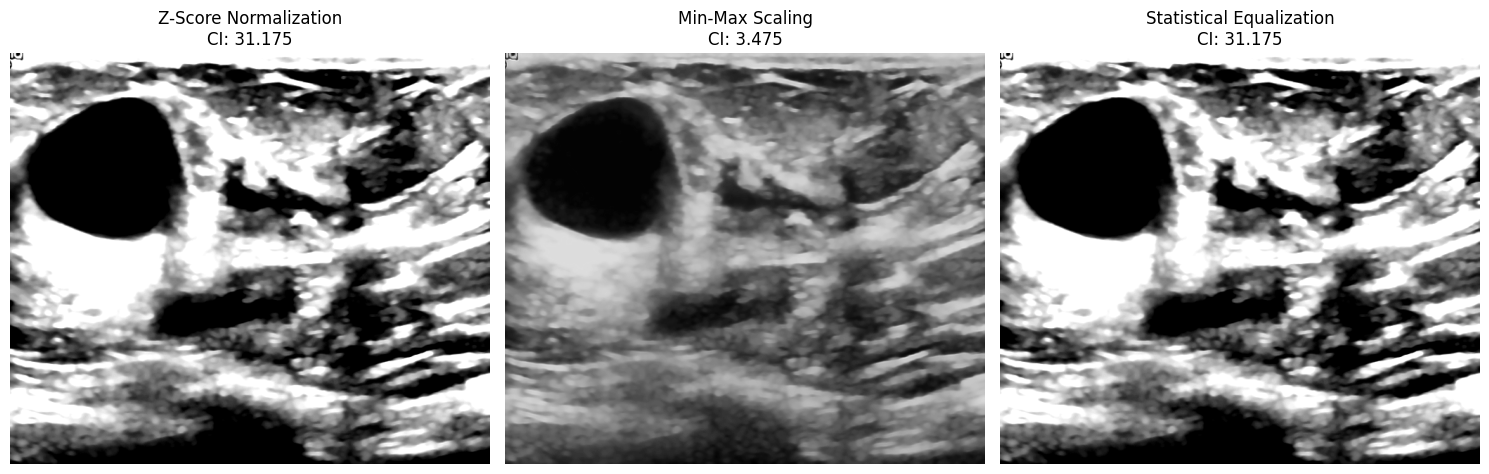

Best Method: Min-Max Scaling with CI: 3.475


In [316]:
best_image = display_and_evaluate_normalization(gbrfltr_img,original_image)

In [317]:
minmax_img = best_image

### FINAL PIPELINE

In [318]:
def median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

In [319]:
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    return clahe.apply(image)

In [320]:
def total_variation_minimization(image, weight=0.1):
    return denoise_tv_chambolle(image, weight=weight)

In [321]:
def contrast_stretching(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

In [322]:
def laplacian_of_gaussian_enhancement(image):
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    blurred_image = cv2.GaussianBlur(image, (9,9), 0)
    edges = cv2.Laplacian(blurred_image, cv2.CV_64F)
    edges = cv2.convertScaleAbs(edges)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR) if len(image.shape) == 3 else edges
    return cv2.addWeighted(image, 0.8, edges_colored.astype(np.uint8), 0.2, 0)

In [323]:
def gradient_domain_edge_enhancement(image):
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    grad_magnitude = cv2.convertScaleAbs(cv2.normalize(cv2.magnitude(grad_x, grad_y), None, 0, 255, cv2.NORM_MINMAX))
    grad_magnitude_colored = cv2.cvtColor(grad_magnitude, cv2.COLOR_GRAY2BGR) if len(image.shape) == 3 else grad_magnitude
    return cv2.addWeighted(image, 0.8, grad_magnitude_colored, 0.2, 0)

In [324]:
def exponential_compensation(image, gamma=0.9):
    return np.array(255 * (image / 255) ** gamma, dtype='uint8')


In [325]:
def gabor_texture_enhancement(image, frequency=0.95):
    filtered_real, _ = gabor(image, frequency=frequency)
    filtered_normalized = cv2.normalize(np.abs(filtered_real), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    return cv2.addWeighted(image, 0.8, filtered_normalized, 0.2, 0)

In [326]:
def min_max_scaling(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

In [327]:
def calculate_psnr(original, processed):
    return peak_signal_noise_ratio(original, processed, data_range=original.max() - original.min())

def calculate_ssim(original, processed):
    return structural_similarity(original, processed, data_range=original.max() - original.min())

def calculate_contrast_improvement_index(original, processed):
    mean_orig, mean_proc = np.mean(original), np.mean(processed)
    std_orig, std_proc = np.std(original), np.std(processed)
    return (std_proc / mean_proc) / (std_orig / mean_orig)

def calculate_f1_score_edges(original, processed):
    edges_original = cv2.Canny(original, 100, 200)
    edges_processed = cv2.Canny(processed, 100, 200)
    f1 = f1_score(edges_original.flatten() > 0, edges_processed.flatten() > 0)
    return f1

In [328]:
def display_and_evaluate_metrics(initial_image, final_image):
    if len(initial_image.shape) == 3:
        initial_image = cv2.cvtColor(initial_image, cv2.COLOR_BGR2GRAY)
    if len(final_image.shape) == 3:
        final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
    
    psnr_value = calculate_psnr(initial_image, final_image)
    ssim_value = calculate_ssim(initial_image, final_image)
    cii_value = calculate_contrast_improvement_index(initial_image, final_image)
    f1_value = calculate_f1_score_edges(initial_image, final_image)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(initial_image, cmap='gray')
    plt.title("Initial Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(final_image, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"PSNR: {psnr_value:.2f}")
    print(f"SSIM: {ssim_value:.3f}")
    print(f"Contrast Improvement Index (CII): {cii_value:.3f}")
    print(f"Edge Detection F1 Score: {f1_value:.3f}")
    
    return {
        'PSNR': psnr_value,
        'SSIM': ssim_value,
        'CII': cii_value,
        'F1 Score': f1_value
    }

In [345]:
def image_enhancement_pipeline(image):
    processed_image = median_filter(image)
    processed_image = apply_clahe(processed_image)
    processed_image = total_variation_minimization(processed_image)
    processed_image = contrast_stretching(processed_image)
    processed_image = laplacian_of_gaussian_enhancement(processed_image)
    processed_image = gradient_domain_edge_enhancement(processed_image)
    processed_image = exponential_compensation(processed_image)
    processed_image = gabor_texture_enhancement(processed_image)
    processed_image = min_max_scaling(processed_image)
    
    return display_and_evaluate_metrics(image, processed_image)

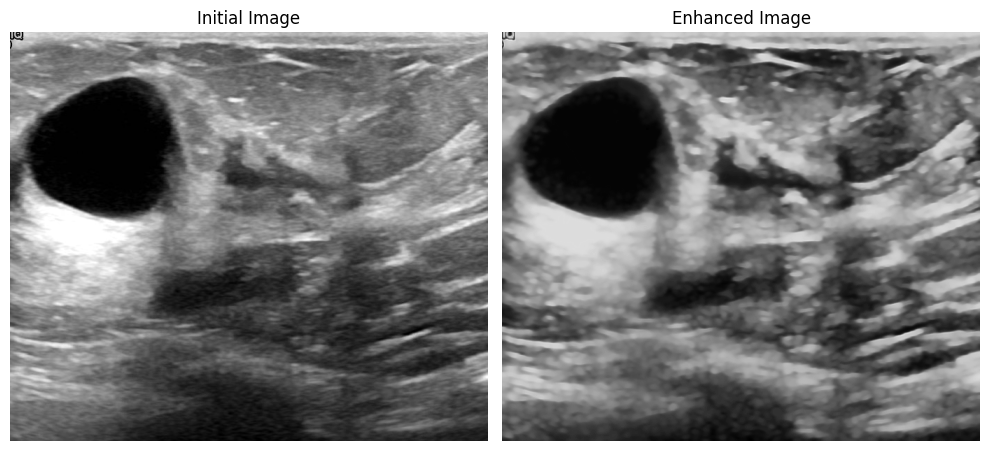

PSNR: 19.63
SSIM: 0.816
Contrast Improvement Index (CII): 0.921
Edge Detection F1 Score: 0.267


{'PSNR': np.float64(19.634294263828338),
 'SSIM': np.float64(0.815520102381854),
 'CII': np.float64(0.9209883643276945),
 'F1 Score': np.float64(0.2666810974619839)}

In [350]:
image = cv2.imread('image2.png', cv2.IMREAD_GRAYSCALE)
image_enhancement_pipeline(image)